Import the libraries that will be used in the analysis.

In [3]:
#Integer division will return float value
from __future__ import division
#Import os to set working directory
import os as osvariable
#Set working directory
osvariable.chdir("C:/Users/Mustafa/Desktop/datamining/Credit_card")
#Import numpy for array operations
import numpy as np
#Suppress scientific notation for numpy
np.set_printoptions(suppress=True)
#Import pandas
import pandas as pd
#Import read_csv to read in csv files
from pandas import read_csv
#%matplotlib inline
%matplotlib inline
#Import plotting library
import matplotlib.pyplot as plt
#Import decision tree
from sklearn import tree
#Import cross_validation for cross validating the models
from sklearn import cross_validation
#Import dummy classifier to compare classifier results to dummy classifier 
#to assess performance
from sklearn.dummy import DummyClassifier
#Import grid search for optimizing hyperparameters
from sklearn.grid_search import GridSearchCV
#train_test_split splits the data into train and test sets  
from sklearn.cross_validation import train_test_split
#VarianceThreshold removes variables with a variance lower than the 
#specified threshold
from sklearn.feature_selection import VarianceThreshold
#Import make_scorer to make a custom score object
from sklearn.metrics import make_scorer
#Import roc_curve and auc to calculate the area under the
#receiving operating characteristics curve
from sklearn.metrics import roc_curve, auc
#Import interpolate to draw the roc_curve
from scipy import interp
#Import the calibration curve to plot the predicted probabilities against
#observed probabilities
from sklearn.calibration import calibration_curve
#Import the classification report to report precision, recall, f-score and support
#for the classes
from sklearn.metrics import classification_report
#Import logistic regression and isotonic regression for probability calibration
from sklearn.linear_model import LogisticRegression as logistic_regression
from sklearn.isotonic import IsotonicRegression as isotonic_regression
#Import pydot to draw the decision tree
import pydot_ng
from sklearn.externals.six import StringIO
#Import the stats library to perform ttest
from scipy import stats

In [4]:
#Read the csv dataframes
X = read_csv('X.csv')
y = read_csv('y.csv')

In [5]:
#Convert the response variable to a numpy array. The response variable
#has to be one dimensional to work with Scikit learn
#Store the variable names in a list first
variable_names = list(X.columns.values)

X = np.array(X)
y = np.ravel(np.array(y))

In [6]:
#We will assume that a false positive costs $5,000
#and a false negative costs $15,000, just to illustrate 
#cost-sensitive learning. We assume that the cost
#of true predictions is zero. For a disccussion of 
#cost-sensitive lerning; see Elkan, "Foundations of 
#Cost-Sensitive Learning" 
cost_false_positive = 5000
cost_false_negative = 15000
cost_true_negative = 0
cost_true_positive = 0
#Before starting to work with the classifiers, 
#we can define our score function which we will 
#use to evaluate the classifiers
def expected_cost(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    proportion_true = np.sum(ground_truth)/len(ground_truth)
    proportion_false = 1 - proportion_true
    true_positive = np.sum((ground_truth + predictions) == 2)
    false_positive = np.sum((ground_truth - predictions) == -1)
    false_negative = np.sum((ground_truth - predictions) == 1)
    true_negative = len(ground_truth) - true_positive - false_positive - false_negative  
    if (true_positive + false_negative) != 0:
        false_negative_rate = false_negative / (true_positive + false_negative)
        true_positive_rate = true_positive / (true_positive + false_negative)
    else:
        false_negative_rate = 0
        true_positive_rate = 0
    if (false_positive + true_negative) != 0:
        false_positive_rate = false_positive / (false_positive + true_negative)
        true_negative_rate = true_negative / (false_positive + true_negative)
    else:
        false_positive_rate = 0
        true_negative_rate = 0
    cost_error = cost_false_positive * false_positive_rate * proportion_false + \
    cost_false_negative * false_negative_rate * proportion_true + \
    cost_true_positive * true_positive_rate * proportion_true + \
    cost_true_negative * true_negative_rate * proportion_false
    return cost_error    

In [7]:
def confusion_matrix_custom(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    true_positive = np.sum((ground_truth + predictions) == 2)
    false_positive = np.sum((ground_truth - predictions) == -1)
    false_negative = np.sum((ground_truth - predictions) == 1)
    true_negative = (len(ground_truth) - true_positive - false_positive - false_negative )
    if (true_positive + false_negative) != 0:
        false_negative_rate = false_negative / (true_positive + false_negative)
    else:
        false_negative_rate = 0
    true_positive_rate = 1 - false_negative_rate
    if (false_positive + true_negative) != 0:
        false_positive_rate = false_positive / (false_positive + true_negative)
    else:
        false_positive_rate = 0    
    true_negative_rate = 1 - false_positive_rate 
    confusion_matrix = np.array([[true_positive_rate, false_positive_rate],[false_negative_rate, true_negative_rate]])      
    #               True    False
    #Test positive   TP      FP  
    #Test negative   FN      TN
    return confusion_matrix  

In [8]:
#Greater is better = False indicates that the result of the cost function is a loss
#the scorer negates the result of the custom loss function, and the highest negated
#value is the best score, which is equivalent to the lowest non-negated value 
score_cost = make_scorer(expected_cost, greater_is_better = False)

#Split the data into a train_validation and test sets. We will use the train_validation
#set to optimize the hyperparameters using crossvalidation, and the final score for the 
#model will be calculated on the test data set.  
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Insert the parameter ranges we want to evaluate.
#For the decision tree, we can look at the performance of the classifier with 
#different depth values.
hyper_parameters_decision_tree = [{'max_depth':[max(1,n_depth * 2) for n_depth in range(21)]}]

#We will perform cross-validation with 5 folds
#Get 5 folds
n_folds = 5
cv = cross_validation.StratifiedKFold(y_train_validation, n_folds = n_folds)

('Decision tree ', 0, 'best parameters', 'true values 0.221')
{'max_depth': 6}
0.521 (+/-0.021) for {'max_depth': 1}
0.530 (+/-0.051) for {'max_depth': 2}
0.568 (+/-0.075) for {'max_depth': 4}
0.590 (+/-0.054) for {'max_depth': 6}
0.588 (+/-0.068) for {'max_depth': 8}
0.580 (+/-0.035) for {'max_depth': 10}
0.554 (+/-0.057) for {'max_depth': 12}
0.536 (+/-0.034) for {'max_depth': 14}
0.531 (+/-0.049) for {'max_depth': 16}
0.513 (+/-0.026) for {'max_depth': 18}
0.491 (+/-0.026) for {'max_depth': 20}
0.475 (+/-0.019) for {'max_depth': 22}
0.458 (+/-0.014) for {'max_depth': 24}
0.452 (+/-0.030) for {'max_depth': 26}
0.432 (+/-0.028) for {'max_depth': 28}
0.427 (+/-0.038) for {'max_depth': 30}
0.418 (+/-0.030) for {'max_depth': 32}
0.421 (+/-0.040) for {'max_depth': 34}
0.408 (+/-0.039) for {'max_depth': 36}
0.411 (+/-0.028) for {'max_depth': 38}
0.407 (+/-0.044) for {'max_depth': 40}
('Decision tree ', 1, 'best parameters', 'true values 0.221')
{'max_depth': 6}
0.523 (+/-0.016) for {'max_d

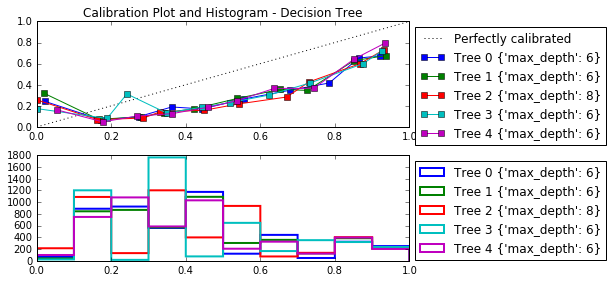

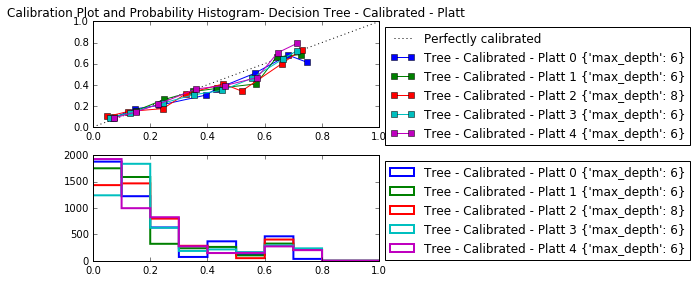

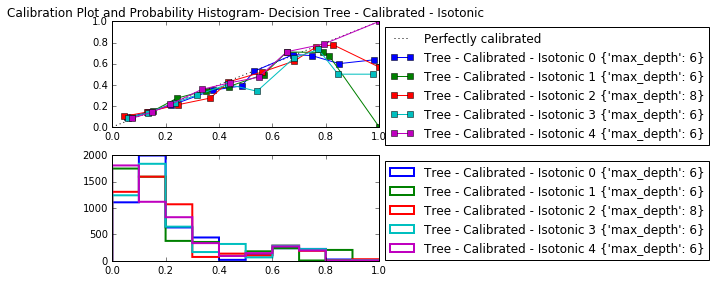

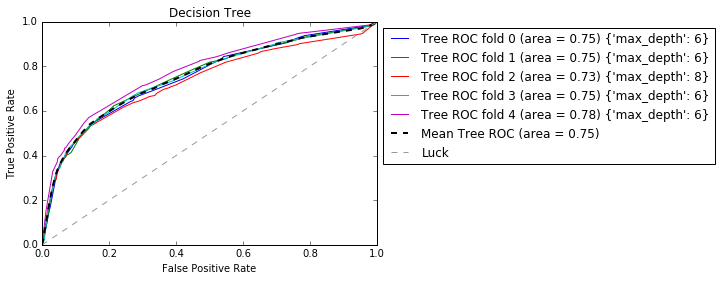

In [9]:
#Start cross validation and draw the ROC curves
mean_tpr_tree = 0.0
mean_fpr_tree = np.linspace(0, 1, 100)

#The first plot will display the Calibration Plot and Histogram
plt.figure(1)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])

#The first plot will display the Calibration Plot and Histogram for 
#probabilities calibrated with Platt's method
plt.figure(2)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])

#The first plot will display the Calibration Plot and Histogram for 
#probabilities calibrated with Isotonic regression
plt.figure(3)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])

#For Platt's method, we fit a logistic regression to the outcomes using the 
#uncalbrated probabilities
lr = logistic_regression()

#Isotonic regressin 
ir = isotonic_regression(out_of_bounds = 'clip')

for i, (train, validation) in enumerate(cv):
    #Start with decision tree
    #We are going to use grid search to find the optimal values
    #scikit-learn uses an optimised version of the CART algorithm.
    #It is more important to capture the customers who default, 
    #therefore 'recall' is the score with which we evaluate the model 
    #performance. We also balance the data by sampling the 'paid' and 'default'
    #classes inversely proportional to their frequency 
    classifier_decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy',splitter = 'best', min_samples_split = 2, max_features = X.shape[1],
                                              min_samples_leaf = 1, min_weight_fraction_leaf=0.0, max_leaf_nodes = None, class_weight = 'balanced',
                                              random_state= None, presort=False)
    #Create an instance of the grid search class
    grid_decision_tree = GridSearchCV(classifier_decision_tree,hyper_parameters_decision_tree,cv = 5, scoring = "recall",refit = True)
    
    #Fit decision tree
    grid_decision_tree.fit(X_train_validation[train],y_train_validation[train])
    print('Decision tree ',i,'best parameters','true values %0.03f' % (sum(y_train_validation[train])/len(y_train_validation[train])))
    print(grid_decision_tree.best_params_)
    for params, mean_score, scores in grid_decision_tree.grid_scores_:
        print('%0.3f (+/-%0.03f) for %r' % (mean_score, scores.std() * 2, params))
    
    #Calibrate probabilities with Platt's method. This is equivalent to fitting a logistic regression to 
    #true class values in the traning set using the uncalibrated predicted probabilities
    probas_tree_train = grid_decision_tree.predict_proba(X_train_validation[train])[:,1]    
    lr.fit(probas_tree_train.reshape( -1, 1 ),y_train_validation[train])    

    #Calibrate probabilities with isotonic regression. Isotonic regression fits a 
    #non-decreasing function to the data
    ir.fit(probas_tree_train,y_train_validation[train])
    
    #Predict the test set in the current fold
    #Use decision tree. Index 1 includes the probabilities of belonging to class '1' (delayed)
    probas_tree_validation = grid_decision_tree.predict_proba(X_train_validation[validation])[:,1]
    #Calculate the calibrated probabilities with Platt's method    
    probas_tree_calibrated_platt = lr.predict_proba(probas_tree_validation.reshape( -1, 1 ))[:,1]
    #Calculate the calibrated probabilities with isotonic regression
    probas_tree_calibrated_isotonic = ir.transform(probas_tree_validation)     
    
    #Plot the calibration curves
    fraction_of_positives_tree, mean_predicted_value_tree = calibration_curve(y_train_validation[validation], probas_tree_validation, n_bins=10)
    #Plot the calibration curves for calibrated probabilities platt
    fraction_of_positives_tree_calibrated_platt, mean_predicted_value_tree_calibrated_platt = calibration_curve(y_train_validation[validation], probas_tree_calibrated_platt, n_bins=10)
    #Plot the calibration curves for calibrated probabilities isotonic
    fraction_of_positives_tree_calibrated_isotonic, mean_predicted_value_tree_calibrated_isotonic = calibration_curve(y_train_validation[validation], probas_tree_calibrated_isotonic, n_bins=10)
            
    # Compute ROC curve and the area under the curve
    fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train_validation[validation], probas_tree_validation)
    mean_tpr_tree += interp(mean_fpr_tree, fpr_tree, tpr_tree)
    mean_tpr_tree[0] = 0.0
    roc_auc_tree = auc(fpr_tree, tpr_tree)
    plt.figure(4)    
    plt.plot(fpr_tree, tpr_tree, lw=1, label='Tree ROC fold %d (area = %0.2f) %r' % (i, roc_auc_tree,grid_decision_tree.best_params_))

    plt.figure(1)
    plt.subplot(211)
    plt.plot(mean_predicted_value_tree,fraction_of_positives_tree,"s-",label = 'Tree %d %r' % (i,grid_decision_tree.best_params_))
    plt.subplot(212)
    plt.hist(probas_tree_validation,range=(0,1),bins= 10, label = "Tree %d %r" % (i,grid_decision_tree.best_params_),histtype = "step", lw = 2)

    plt.figure(2)    
    plt.subplot(211)
    plt.plot(mean_predicted_value_tree_calibrated_platt,fraction_of_positives_tree_calibrated_platt,"s-",label = 'Tree - Calibrated - Platt %d %r' % (i,grid_decision_tree.best_params_))
    plt.subplot(212)
    plt.hist(probas_tree_calibrated_platt,range=(0,1),bins= 10, label = "Tree - Calibrated - Platt %d %r" % (i,grid_decision_tree.best_params_),histtype = "step", lw = 2)
    
    plt.figure(3)    
    plt.subplot(211)
    plt.plot(mean_predicted_value_tree_calibrated_isotonic,fraction_of_positives_tree_calibrated_isotonic,"s-",label = 'Tree - Calibrated - Isotonic %d %r' % (i,grid_decision_tree.best_params_))
    plt.subplot(212)
    plt.hist(probas_tree_calibrated_isotonic,range=(0,1),bins= 10, label = "Tree - Calibrated - Isotonic %d %r" % (i,grid_decision_tree.best_params_),histtype = "step", lw = 2)
       
#Draw the mean ROC curve
plt.figure(4)    
mean_tpr_tree /= len(cv)
mean_tpr_tree[-1] = 1.0
mean_auc_tree = auc(mean_fpr_tree, mean_tpr_tree)
plt.plot(mean_fpr_tree, mean_tpr_tree, 'k--',label='Mean Tree ROC (area = %0.2f)' % mean_auc_tree, lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.title('Decision Tree')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig('Mean Tree ROC')

plt.figure(1)
plt.subplot(211)
plt.title('Calibration Plot and Histogram - Decision Tree')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Decision Tree')

plt.figure(2)
plt.subplot(211)
plt.title('Calibration Plot and Probability Histogram- Decision Tree - Calibrated - Platt')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Decision Tree - Calibrated - Platt')

plt.figure(3)
plt.subplot(211)
plt.title('Calibration Plot and Probability Histogram- Decision Tree - Calibrated - Isotonic')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Decision Tree - Calibrated - Isotonic')

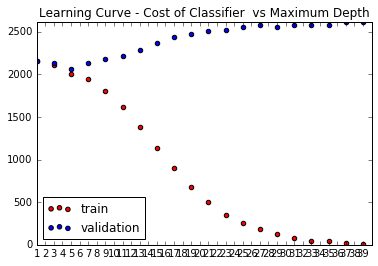

In [10]:
#Plot the learning curve to assess the fit as the max depth of the tree increases
train_cost = []
validation_cost = []

train_cost_cv = np.zeros((n_folds))
validation_cost_cv = np.zeros((n_folds))

steps = xrange(1,41,2)


for i in steps:
    classifier_decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy',splitter = 'best',max_features= X.shape[1], min_samples_split = 2, 
                                          min_samples_leaf = 1, min_weight_fraction_leaf=0.0, max_depth = i, max_leaf_nodes = None, class_weight = 'balanced',
                                          random_state= None, presort=False)
    for j, (train, validation) in enumerate(cv):
        classifier_decision_tree.fit(X_train_validation[train], y_train_validation[train])
        train_predictions = classifier_decision_tree.predict(X_train_validation[train])
        test_predictions = classifier_decision_tree.predict(X_train_validation[validation])                                  
        train_cost_cv[j] = expected_cost(y_train_validation[train], train_predictions)         
        validation_cost_cv[j] = expected_cost(y_train_validation[validation], test_predictions)
    train_cost.append(np.mean(train_cost_cv))
    validation_cost.append(np.mean(validation_cost_cv))
        
plt.figure(5)    
plt.scatter(steps, train_cost, c = 'red',label = 'train')
plt.scatter(steps, validation_cost, c = 'blue',label = 'validation')
plt.xticks(np.arange(1, max(steps) + 1, 1))
plt.xlim([1,max(steps) + 1])
plt.ylim([0,max(max(train_cost),max(validation_cost)) + 1])
plt.title('Learning Curve - Cost of Classifier  vs Maximum Depth')
plt.legend(loc="lower left")
plt.savefig('Learning Curve')

In [11]:
#We are going to use 6 as the max tree depth. This gave the best result in the 
#grid search, and the learning curve shows that beyond this depth the tree starts to 
#overfit, as indicated by the increasing validation cost
classifier_decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy',splitter = 'best',max_features= X_train_validation.shape[1], min_samples_split = 2, 
                                          min_samples_leaf = 1, min_weight_fraction_leaf=0.0, max_depth = 6, max_leaf_nodes = None, class_weight = 'balanced',
                                          random_state= None, presort=False)
                                          
#Use the train and validation data to fit the model with the optimal parameter
classifier_decision_tree.fit(X_train_validation,y_train_validation) 
                          
#Get training probabilities for probability calibration
decision_tree_probabilities_train = classifier_decision_tree.predict_proba(X_train_validation)[:,1]

#calibrate probabilities with isotonic regression
ir.fit(decision_tree_probabilities_train,y_train_validation)                          
           
#calibrate probabilities with platt's method
lr.fit(decision_tree_probabilities_train.reshape( -1, 1 ),y_train_validation) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
#Draw the decision tree
classlist = ['Pay','Default']
dot_data = StringIO()  
tree.export_graphviz(classifier_decision_tree, out_file=dot_data,  
                         feature_names=variable_names,  
                         class_names=classlist,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot_ng.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("tree_classifier.png") 

True

In [13]:
#Get the feature importances and names in dataframe
importance = pd.DataFrame(classifier_decision_tree.feature_importances_,columns = ['Importance'],index = variable_names)
importance = importance.sort_values(by = 'Importance', axis = 0, ascending = False)
pd.DataFrame(importance).to_csv('importance.csv',index = False)
print(importance[:10])

           Importance
PAY_0        0.690733
PAY_AMT2     0.068742
PAY_4        0.056730
PAY_2        0.036987
BILL_AMT1    0.021182
LIMIT_BAL    0.018905
PAY_AMT4     0.018462
PAY_AMT3     0.017935
BILL_AMT2    0.017692
AGE          0.010311


In [14]:
#Set the threshold for classifying the observations as true.
threshold_cost = (cost_false_positive + cost_true_negative) / (cost_false_positive - cost_true_negative + cost_false_negative - cost_true_positive)
threshold_05 = 0.5

#Use the decision tree model on the test set and get uncalibrated probabilities
decision_tree_probabilities_test = classifier_decision_tree.predict_proba(X_test)[:,1]

#Use the cost sensitive threshold to predict the outcome
decision_tree_predictions_test_cost = [0 if x < threshold_cost else 1 for x in decision_tree_probabilities_test]
#Use the 50% threshold to predict the outcome
decision_tree_predictions_test_50 = [0 if x < threshold_05 else 1 for x in decision_tree_probabilities_test]

#Calibrate the probabilities by isotonic regression 
probas_tree_calibrated_isotonic = ir.transform(decision_tree_probabilities_test)
#Use the cost sensitive threshold to predict the outcome
decision_tree_predictions_test_calibrated_isotonic_cost = [0 if x < threshold_cost else 1 for x in probas_tree_calibrated_isotonic]
#Use the 50% threshold to predict the outcome
decision_tree_predictions_test_calibrated_isotonic_50 = [0 if x < threshold_05 else 1 for x in probas_tree_calibrated_isotonic]

#Calibrate the probabilities by isotonic regression 
probas_tree_calibrated_platt = lr.predict_proba(decision_tree_probabilities_test.reshape( -1, 1 ))[:,1]
#Use the cost sensitive threshold to predict the outcome
decision_tree_predictions_test_calibrated_platts_cost = [0 if x < threshold_cost else 1 for x in probas_tree_calibrated_platt]
#Use the 50% threshold to predict the outcome
decision_tree_predictions_test_calibrated_platts_50 = [0 if x < threshold_05 else 1 for x in probas_tree_calibrated_platt]

#Compare the decision tree classifier's expected cost to that of a dummy
#classifier which simply assigns all observations to the majority class
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf = clf.fit(X_train_validation, y_train_validation)
clf_predictions = clf.predict(X_test)

In [15]:
#Print the expected cost and the classification report for uncalibrated probabilities, 
#isotonic calibrated probabilities and platts calibrated probabilities
#with cost-sensitive threshold and 50% threshold
print('Uncalibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_cost))
print(classification_report(y_test, decision_tree_predictions_test_cost,target_names = ['Pay','Default']))

print('Uncalibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_50))
print(classification_report(y_test, decision_tree_predictions_test_50,target_names = ['Pay','Default']))

print('Isotonic calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_calibrated_isotonic_cost))
print(classification_report(y_test, decision_tree_predictions_test_calibrated_isotonic_cost,target_names = ['Pay','Default']))

print('Isotonic calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_calibrated_isotonic_50))
print(classification_report(y_test, decision_tree_predictions_test_calibrated_isotonic_50,target_names = ['Pay','Default']))

print('Platts calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_calibrated_platts_cost))
print(classification_report(y_test, decision_tree_predictions_test_calibrated_platts_cost,target_names = ['Pay','Default']))

print('Platts calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_calibrated_platts_50))
print(classification_report(y_test, decision_tree_predictions_test_calibrated_platts_50,target_names = ['Pay','Default']))

print('Dummy classifier: %i ' % expected_cost(y_test, clf_predictions))
print(classification_report(y_test, clf_predictions,target_names = ['Pay','Default']))

Uncalibrated probabilities, cost sensitive threshold: 3095 
             precision    recall  f1-score   support

        Pay       0.93      0.26      0.41      4663
    Default       0.27      0.93      0.41      1337

avg / total       0.78      0.41      0.41      6000

Uncalibrated probabilities, 50pct threshold: 2136 
             precision    recall  f1-score   support

        Pay       0.87      0.84      0.85      4663
    Default       0.50      0.54      0.52      1337

avg / total       0.78      0.78      0.78      6000

Isotonic calibrated probabilities, cost sensitive threshold: 2138 
             precision    recall  f1-score   support

        Pay       0.87      0.84      0.85      4663
    Default       0.50      0.54      0.52      1337

avg / total       0.78      0.78      0.78      6000

Isotonic calibrated probabilities, 50pct threshold: 2312 
             precision    recall  f1-score   support

        Pay       0.84      0.95      0.89      4663
    Default 

C:\Users\Mustafa\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The smallest cost is given by using probabilities calibrated with Platt's method and a cost-sensitive threshold, the same as uncalibrated probabilities and a 50% threshold. But the calibration plots suggest that the probabilities adjusted with the Platt's method are closer to observed probabilities. The dummy classifier which predicts 'payment' for all instances (assigns the majority class) has the highest cost.

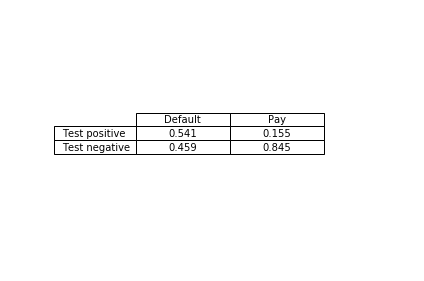

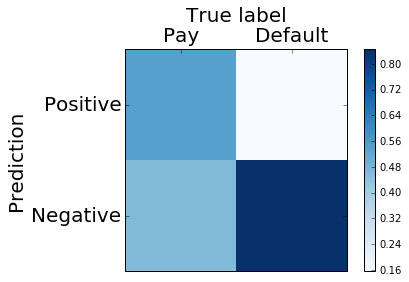

In [16]:
#Plot the confusion matrix 
cm = confusion_matrix_custom(y_test,decision_tree_predictions_test_calibrated_isotonic_cost)
cm = np.round(cm, decimals = 3)
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=cm,
          rowLabels=['Test positive','Test negative'],
          colLabels=['Default','Pay'],
          cellLoc='center',colWidths=[0.25, 0.25],
          loc='center')
plt.tight_layout()

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues, interpolation='none')
fig.colorbar(im)
locs = np.arange(len(np.unique(y_test)))
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks(locs + 0.5)
ax.xaxis.set(ticks=locs, ticklabels=['Pay','Default'])
ax.yaxis.set_ticks(locs + 0.5)
ax.yaxis.set(ticks=locs, ticklabels=['Positive','Negative'])
plt.xlabel('True label', fontsize=20)
plt.ylabel('Prediction', fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
ax.grid(False) 